# PACKAGES

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt

from mplsoccer import Pitch, VerticalPitch, FontManager, Sbopen
from matplotlib.colors import LinearSegmentedColormap

import plotly.express as px

from sqlalchemy import create_engine
import pymysql
from pymysql.cursors import DictCursor
import pymysql.cursors

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve

import xgboost as xgb

#import warnings
#warnings.filterwarnings('ignore')

# DATA QUERY

In [2]:
username = 'root'          
password = ''               
host = 'localhost'         
port = '3306'              
database = 'top7_leagues' 

# Create the SQLAlchemy engine
engine = create_engine(f'mysql+pymysql://{username}:{password}@{host}:{port}/{database}')

In [11]:
query = "SELECT * FROM match_events_2023_24"
df_events = pd.read_sql(query, engine)

In [13]:
df_events.head()

,id,match_id,event_id,minute,second,team_id,player_id,x,y,end_x,...,blocked_x,blocked_y,goal_mouth_z,goal_mouth_y,is_shot,card_type,is_goal,type_display_name,outcome_type_display_name,period_display_name
0,2602361573,1734766,3,0,0.0,54,135366,50.1,50.0,46.4,...,NaN,NaN,NaN,NaN,0,0,0,Pass,Successful,FirstHalf
1,2602361601,1734766,4,0,1.0,54,82989,46.1,49.7,31.9,...,NaN,NaN,NaN,NaN,0,0,0,Pass,Successful,FirstHalf
2,2602361647,1734766,5,0,4.0,54,125211,31.8,13.1,20.8,...,NaN,NaN,NaN,NaN,0,0,0,Pass,Successful,FirstHalf
3,2602361695,1734766,6,0,6.0,54,121456,20.8,30.8,20.1,...,NaN,NaN,NaN,NaN,0,0,0,Pass,Successful,FirstHalf
4,2602361767,1734766,7,0,9.0,54,454342,19.4,64.2,18.1,...,NaN,NaN,NaN,NaN,0,0,0,Pass,Successful,FirstHalf


# DATA PROCESSING

The data provided by WhoScored includes many valuable details that will aid in creating the xG model.

## Data Standardization and Cleanup

In [14]:
def transform_data(df_events):
    
    # Apply transformations to x and y coordinates (intially 100 x 100)
    for col in ['x', 'end_x','blocked_x']:
        df_events.loc[:, col] *= 1.2
    for col in ['y', 'end_y', 'blocked_y', 'goal_mouth_y']:
        df_events.loc[:, col] = 80 - (df_events[col] * 0.8)    

    df_shots = df_events[(df_events['is_shot']==1) & (df_events['x']>40)]

    df_shots.loc[:, 'is_penalty'] = np.where((df_shots['x'] == 106.2) & (df_shots['y'] == 40), 1, 0)
    
    columns_to_drop = ['id', 'match_id', 'event_id', 'second','team_id', 'player_id', 
                       'qualifiers', 'card_type', 'outcome_type_display_name','is_touch',
                       'period_display_name','end_x','end_y']
    df_shots = df_shots.drop(columns=columns_to_drop)

    # Mapping logic: 1 = on target, 0 = off target
    df_shots['is_on_target'] = df_shots['type_display_name'].map({
        'MissedShots': 0,
        'SavedShot': 1,
        'ShotOnPost': 0,
        'Goal': 1
    })

    df_shots['is_blocked'] = df_shots['blocked_x'].notna().astype(int)
    df_shots['distance_blocker_goal'] = np.sqrt((df_shots['blocked_x'] - 120)**2 + (df_shots['blocked_y'] - 40)**2)
    df_shots['distance_shooter_blocker'] = np.sqrt((df_shots['blocked_x'] - df_shots['x'])**2 + (df_shots['blocked_y'] - df_shots['y'])**2)
    
    columns_to_drop = ['type_display_name','is_shot']
    df_shots = df_shots.drop(columns=columns_to_drop)
    
    # Goal center coordinates
    goal_x = 120
    goal_y = 40
    
    # Calculate shot distance
    df_shots['shot_distance'] = np.sqrt((df_shots['x'] - goal_x)**2 + (df_shots['y'] - goal_y)**2)
    
    # Calculate shot angle in radians
    df_shots['shot_angle'] = np.arctan2(np.abs(df_shots['y'] - goal_y), np.abs(goal_x - df_shots['x']))
    
    # Convert angle to degrees (optional)
    df_shots['shot_angle_deg'] = np.degrees(df_shots['shot_angle'])
    
    df_shots = df_shots.drop(columns=['shot_angle'])

    return df_shots


In [15]:
df_shots = transform_data(df_events)

/var/folders/2v/q5fxrfkj08s4gx6nrq6bhgqc0000gn/T/ipykernel_88858/1169704693.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shots.loc[:, 'is_penalty'] = np.where((df_shots['x'] == 106.2) & (df_shots['y'] == 40), 1, 0)


In [16]:
df_shots.head()

,minute,x,y,blocked_x,blocked_y,goal_mouth_z,goal_mouth_y,is_goal,is_penalty,is_on_target,is_blocked,distance_blocker_goal,distance_shooter_blocker,shot_distance,shot_angle_deg
75,4,117.48,47.68,NaN,NaN,72.2,46.64,0,0,0,0,NaN,NaN,8.082871,71.834043
217,12,97.32,41.92,117.72,40.16,5.1,41.84,0,0,1,1,2.285607,20.475781,22.761125,4.838899
296,17,110.04,35.60,NaN,NaN,6.9,33.60,0,0,0,0,NaN,NaN,10.888600,23.834263
305,17,107.40,35.60,NaN,NaN,80.6,37.12,0,0,0,0,NaN,NaN,13.346160,19.249526
395,23,108.12,22.88,NaN,NaN,5.7,44.48,0,0,0,0,NaN,NaN,20.838157,55.242243


## Data Standardization and Cleanup v0

In [5]:
# Apply transformations to x and y coordinates (intially 100 x 100)
for col in ['x', 'end_x','blocked_x']:
    df_events.loc[:, col] *= 1.2
for col in ['y', 'end_y', 'blocked_y', 'goal_mouth_y']:
    df_events.loc[:, col] = 80 - (df_events[col] * 0.8)

In [221]:
df_shots = df_events[(df_events['is_shot']==1) & (df_events['x']>40)]

In [223]:
# Identify penalties
df_shots.loc[:, 'is_penalty'] = np.where((df_shots['x'] == 106.2) & (df_shots['y'] == 40), 1, 0)

In [224]:
df_shots.columns

Index(['id', 'match_id', 'event_id', 'minute', 'second', 'team_id',
       'player_id', 'x', 'y', 'end_x', 'end_y', 'qualifiers', 'is_touch',
       'blocked_x', 'blocked_y', 'goal_mouth_z', 'goal_mouth_y', 'is_shot',
       'card_type', 'is_goal', 'type_display_name',
       'outcome_type_display_name', 'period_display_name', 'is_penalty'],
      dtype='object')

In [225]:
columns_to_drop = ['id', 'match_id', 'event_id', 'second','team_id', 'player_id', 
                   'qualifiers', 'card_type', 'outcome_type_display_name','is_touch',
                   'period_display_name','end_x','end_y']
df_shots = df_shots.drop(columns=columns_to_drop)

In [226]:
df_shots['type_display_name'].unique()

array(['MissedShots', 'SavedShot', 'ShotOnPost', 'Goal'], dtype=object)

In [227]:
# Mapping logic: 1 = on target, 0 = off target
df_shots['is_on_target'] = df_shots['type_display_name'].map({
    'MissedShots': 0,
    'SavedShot': 1,
    'ShotOnPost': 0,
    'Goal': 1
})

In [228]:
df_shots['is_blocked'] = df_shots['blocked_x'].notna().astype(int)

In [229]:
df_shots['distance_blocker_goal'] = np.sqrt((df_shots['blocked_x'] - 120)**2 + (df_shots['blocked_y'] - 40)**2)
df_shots['distance_shooter_blocker'] = np.sqrt((df_shots['blocked_x'] - df_shots['x'])**2 + (df_shots['blocked_y'] - df_shots['y'])**2)

In [230]:
columns_to_drop = ['type_display_name','is_shot']
df_shots = df_shots.drop(columns=columns_to_drop)

In [231]:
df_shots.head()

,minute,x,y,blocked_x,blocked_y,goal_mouth_z,goal_mouth_y,is_goal,is_penalty,is_on_target,is_blocked,distance_blocker_goal,distance_shooter_blocker
75,4,117.48,47.68,NaN,NaN,72.2,46.64,0,0,0,0,NaN,NaN
217,12,97.32,41.92,117.72,40.16,5.1,41.84,0,0,1,1,2.285607,20.475781
296,17,110.04,35.60,NaN,NaN,6.9,33.60,0,0,0,0,NaN,NaN
305,17,107.40,35.60,NaN,NaN,80.6,37.12,0,0,0,0,NaN,NaN
395,23,108.12,22.88,NaN,NaN,5.7,44.48,0,0,0,0,NaN,NaN


In [232]:
# Goal center coordinates
goal_x = 120
goal_y = 40

# Calculate shot distance
df_shots['shot_distance'] = np.sqrt((df_shots['x'] - goal_x)**2 + (df_shots['y'] - goal_y)**2)

# Calculate shot angle in radians
df_shots['shot_angle'] = np.arctan2(np.abs(df_shots['y'] - goal_y), np.abs(goal_x - df_shots['x']))

# Convert angle to degrees (optional)
df_shots['shot_angle_deg'] = np.degrees(df_shots['shot_angle'])

In [233]:
# Drop the 'shot_angle' column
df_shots = df_shots.drop(columns=['shot_angle'])

In [234]:
df_shots.head()

,minute,x,y,blocked_x,blocked_y,goal_mouth_z,goal_mouth_y,is_goal,is_penalty,is_on_target,is_blocked,distance_blocker_goal,distance_shooter_blocker,shot_distance,shot_angle_deg
75,4,117.48,47.68,NaN,NaN,72.2,46.64,0,0,0,0,NaN,NaN,8.082871,71.834043
217,12,97.32,41.92,117.72,40.16,5.1,41.84,0,0,1,1,2.285607,20.475781,22.761125,4.838899
296,17,110.04,35.60,NaN,NaN,6.9,33.60,0,0,0,0,NaN,NaN,10.888600,23.834263
305,17,107.40,35.60,NaN,NaN,80.6,37.12,0,0,0,0,NaN,NaN,13.346160,19.249526
395,23,108.12,22.88,NaN,NaN,5.7,44.48,0,0,0,0,NaN,NaN,20.838157,55.242243


In [235]:
df_shots.sort_values(by='shot_distance',ascending=False,inplace=True)
df_shots

,minute,x,y,blocked_x,blocked_y,goal_mouth_z,goal_mouth_y,is_goal,is_penalty,is_on_target,is_blocked,distance_blocker_goal,distance_shooter_blocker,shot_distance,shot_angle_deg
1248517,97,40.32,53.52,NaN,NaN,2.8,11.04,0,0,0,0,NaN,NaN,80.818889,9.630153
733477,74,48.96,76.08,113.04,59.36,6.9,53.52,0,0,0,1,20.573070,66.225409,79.677149,26.925235
3201999,14,42.96,55.76,NaN,NaN,12.5,63.44,0,0,0,0,NaN,NaN,78.635483,11.561429
1011947,7,42.24,48.96,97.44,40.40,13.3,39.44,0,0,1,1,22.563546,55.859767,78.274512,6.572995
2004014,53,43.44,24.96,NaN,NaN,11.1,33.44,0,0,0,0,NaN,NaN,78.023299,11.114070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129957,11,118.80,39.12,117.72,25.28,1.4,0.56,0,0,0,1,14.895530,13.882075,1.488086,36.253838
573904,8,118.68,39.84,NaN,NaN,12.7,39.84,1,0,1,0,NaN,NaN,1.329662,6.911227
22859,76,118.80,39.84,NaN,NaN,3.2,38.56,1,0,1,0,NaN,NaN,1.210620,7.594643
1621520,45,119.40,40.96,NaN,NaN,1.9,40.64,1,0,1,0,NaN,NaN,1.132078,57.994617


In [236]:
df_shots.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62142 entries, 1248517 to 3267431
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   minute                    62142 non-null  int64  
 1   x                         62142 non-null  float64
 2   y                         62142 non-null  float64
 3   blocked_x                 35136 non-null  float64
 4   blocked_y                 35136 non-null  float64
 5   goal_mouth_z              62142 non-null  float64
 6   goal_mouth_y              62142 non-null  float64
 7   is_goal                   62142 non-null  int64  
 8   is_penalty                62142 non-null  int64  
 9   is_on_target              62142 non-null  int64  
 10  is_blocked                62142 non-null  int64  
 11  distance_blocker_goal     35136 non-null  float64
 12  distance_shooter_blocker  35136 non-null  float64
 13  shot_distance             62142 non-null  float64
 14  sho

## % of scoring based on Distance, Angle & Minute

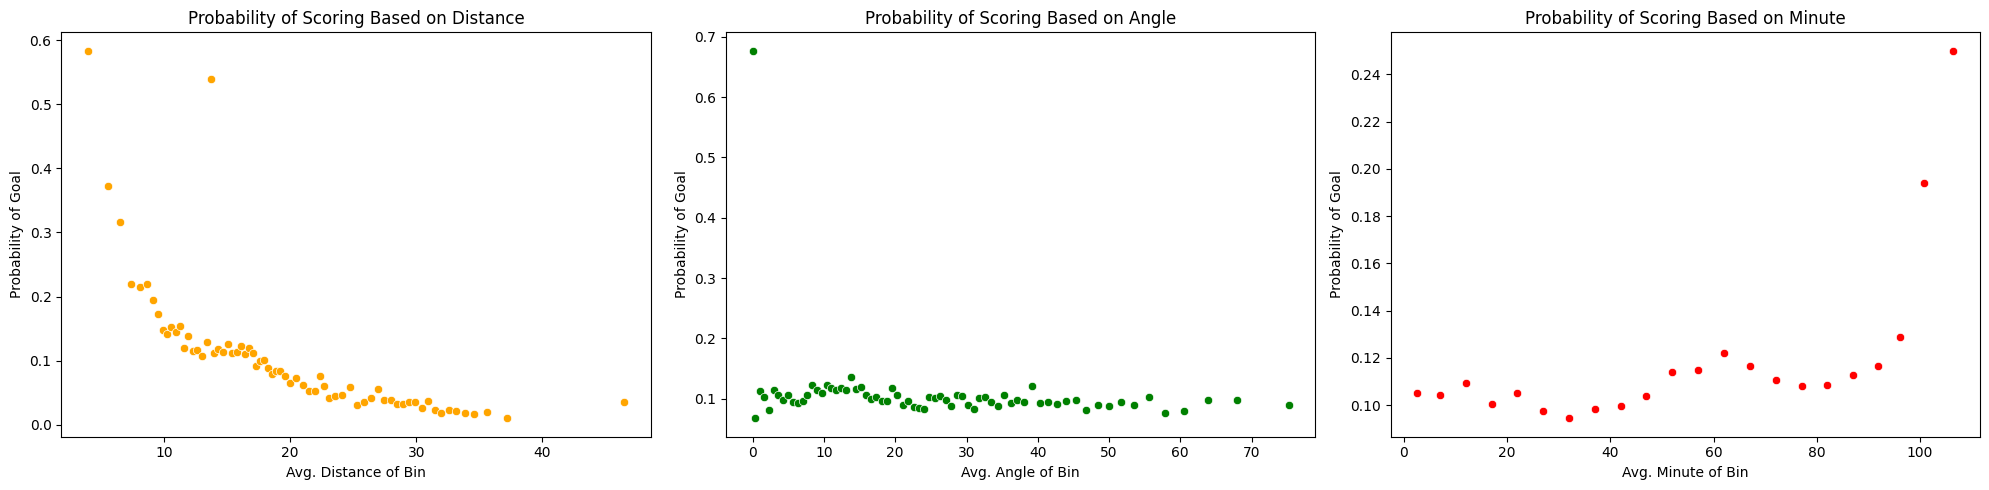

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# 1. Probability of Scoring Based on Distance
df_shots['Distance_Bins'] = pd.qcut(df_shots['shot_distance'], q=70)
dist_prob = df_shots.groupby('Distance_Bins', as_index=False)['is_goal'].mean()
dist_mean = df_shots.groupby('Distance_Bins', as_index=False)['shot_distance'].mean()
sns.scatterplot(x=dist_mean['shot_distance'], y=dist_prob['is_goal'], ax=axes[0], color="orange")
axes[0].set_xlabel("Avg. Distance of Bin")
axes[0].set_ylabel("Probability of Goal")
axes[0].set_title("Probability of Scoring Based on Distance")

# 2. Probability of Scoring Based on Angle
df_shots['Angle_Bins'] = pd.qcut(df_shots['shot_angle_deg'], q=70)
angle_prob = df_shots.groupby('Angle_Bins', as_index=False)['is_goal'].mean()
angle_mean = df_shots.groupby('Angle_Bins', as_index=False)['shot_angle_deg'].mean()
sns.scatterplot(x=angle_mean['shot_angle_deg'], y=angle_prob['is_goal'], ax=axes[1], color="green")
axes[1].set_xlabel("Avg. Angle of Bin")
axes[1].set_ylabel("Probability of Goal")
axes[1].set_title("Probability of Scoring Based on Angle")

# 3. Probability of Scoring Based on Minute
minute_bins = np.linspace(df_shots['minute'].min(), df_shots['minute'].max(), 23)
df_shots['Minute_Bins'] = pd.cut(df_shots['minute'], bins=minute_bins)
minute_prob = df_shots.groupby('Minute_Bins', as_index=False)['is_goal'].mean()
minute_mean = df_shots.groupby('Minute_Bins', as_index=False)['minute'].mean()
sns.scatterplot(x=minute_mean['minute'], y=minute_prob['is_goal'], ax=axes[2], color="red")
axes[2].set_xlabel("Avg. Minute of Bin")
axes[2].set_ylabel("Probability of Goal")
axes[2].set_title("Probability of Scoring Based on Minute")


plt.tight_layout()
plt.show()

The distance feature shows a clearer pattern in the probability of scoring compared to the angle and minute features.

In [18]:
df_shots.drop(columns=['Distance_Bins', 'Angle_Bins', 'Minute_Bins'], inplace=True)

# MACHINE LEARNING

## Preparing Data for Model Training

In [19]:
# Fill missing values with -1 for distance-related features
df_shots['distance_blocker_goal'].fillna(-1, inplace=True)
df_shots['distance_shooter_blocker'].fillna(-1, inplace=True)

# For blocked_x and blocked_y, you can also use -1 if you want to distinguish them from valid values
df_shots['blocked_x'].fillna(0, inplace=True)
df_shots['blocked_y'].fillna(0, inplace=True)

In [20]:
df_shots.head()

,minute,x,y,blocked_x,blocked_y,goal_mouth_z,goal_mouth_y,is_goal,is_penalty,is_on_target,is_blocked,distance_blocker_goal,distance_shooter_blocker,shot_distance,shot_angle_deg
75,4,117.48,47.68,0.00,0.00,72.2,46.64,0,0,0,0,-1.000000,-1.000000,8.082871,71.834043
217,12,97.32,41.92,117.72,40.16,5.1,41.84,0,0,1,1,2.285607,20.475781,22.761125,4.838899
296,17,110.04,35.60,0.00,0.00,6.9,33.60,0,0,0,0,-1.000000,-1.000000,10.888600,23.834263
305,17,107.40,35.60,0.00,0.00,80.6,37.12,0,0,0,0,-1.000000,-1.000000,13.346160,19.249526
395,23,108.12,22.88,0.00,0.00,5.7,44.48,0,0,0,0,-1.000000,-1.000000,20.838157,55.242243


In [97]:
# Define features and target
features = ['shot_distance', 'shot_angle_deg','is_penalty','x']
target = 'is_goal'

# Define feature matrix and target vector
X = df_shots[features]
y = df_shots[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = X_train  # Use raw data without scaling
X_test_scaled = X_test

After refining the features, I chose to exclude the is_on_target feature. This decision stems from the fact that if a shot is on target (is_on_target == 1) and it hasn’t been blocked (is_blocked == 0), it inevitably results in a goal. The models quickly recognized this pattern, leading to an inflated 100% precision, which distorted the evaluation of other features.

## Models' Training

In [98]:
# Initialize models
lr_model = LogisticRegression(max_iter=100)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model = xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False)


# Train Logistic Regression
lr_model.fit(X_train_scaled, y_train)

# Train Random Forest
rf_model.fit(X_train_scaled, y_train)

# Train XGBoost
xgb_model.fit(X_train_scaled, y_train)



# Make predictions for each model
y_pred_lr = lr_model.predict(X_test_scaled)
y_prob_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

y_pred_rf = rf_model.predict(X_test_scaled)
y_prob_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

y_pred_xgb = xgb_model.predict(X_test_scaled)
y_prob_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

In [99]:
# Generate classification reports and ROC AUC scores for each model
results = {
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "Accuracy": [
        roc_auc_score(y_test, y_prob_lr),
        roc_auc_score(y_test, y_prob_rf),
        roc_auc_score(y_test, y_prob_xgb)
    ],
    "Precision Non-Goal": [
        classification_report(y_test, y_pred_lr, output_dict=True)['0']['precision'],
        classification_report(y_test, y_pred_rf, output_dict=True)['0']['precision'],
        classification_report(y_test, y_pred_xgb, output_dict=True)['0']['precision']
    ],
    "Precision Goal": [
        classification_report(y_test, y_pred_lr, output_dict=True)['1']['precision'],
        classification_report(y_test, y_pred_rf, output_dict=True)['1']['precision'],
        classification_report(y_test, y_pred_xgb, output_dict=True)['1']['precision']
    ],
    "Recall Non-Goal": [
        classification_report(y_test, y_pred_lr, output_dict=True)['0']['recall'],
        classification_report(y_test, y_pred_rf, output_dict=True)['0']['recall'],
        classification_report(y_test, y_pred_xgb, output_dict=True)['0']['recall']
    ],
    "Recall Goal": [
        classification_report(y_test, y_pred_lr, output_dict=True)['1']['recall'],
        classification_report(y_test, y_pred_rf, output_dict=True)['1']['recall'],
        classification_report(y_test, y_pred_xgb, output_dict=True)['1']['recall']
    ]
}

models_results = pd.DataFrame(results)
models_results

,Model,Accuracy,Precision Non-Goal,Precision Goal,Recall Non-Goal,Recall Goal
0,Logistic Regression,0.750088,0.897632,0.807860,0.997345,0.089372
1,Random Forest,0.666713,0.907292,0.353705,0.948953,0.223671
2,XGBoost,0.736558,0.903862,0.660569,0.989923,0.157005


The XGBoost model outperforms both Logistic Regression and Random Forest in terms of accuracy, precision, and recall, particularly for predicting goals. 
### To verify these results, a confusion matrix and precision-recall analysis are being set up

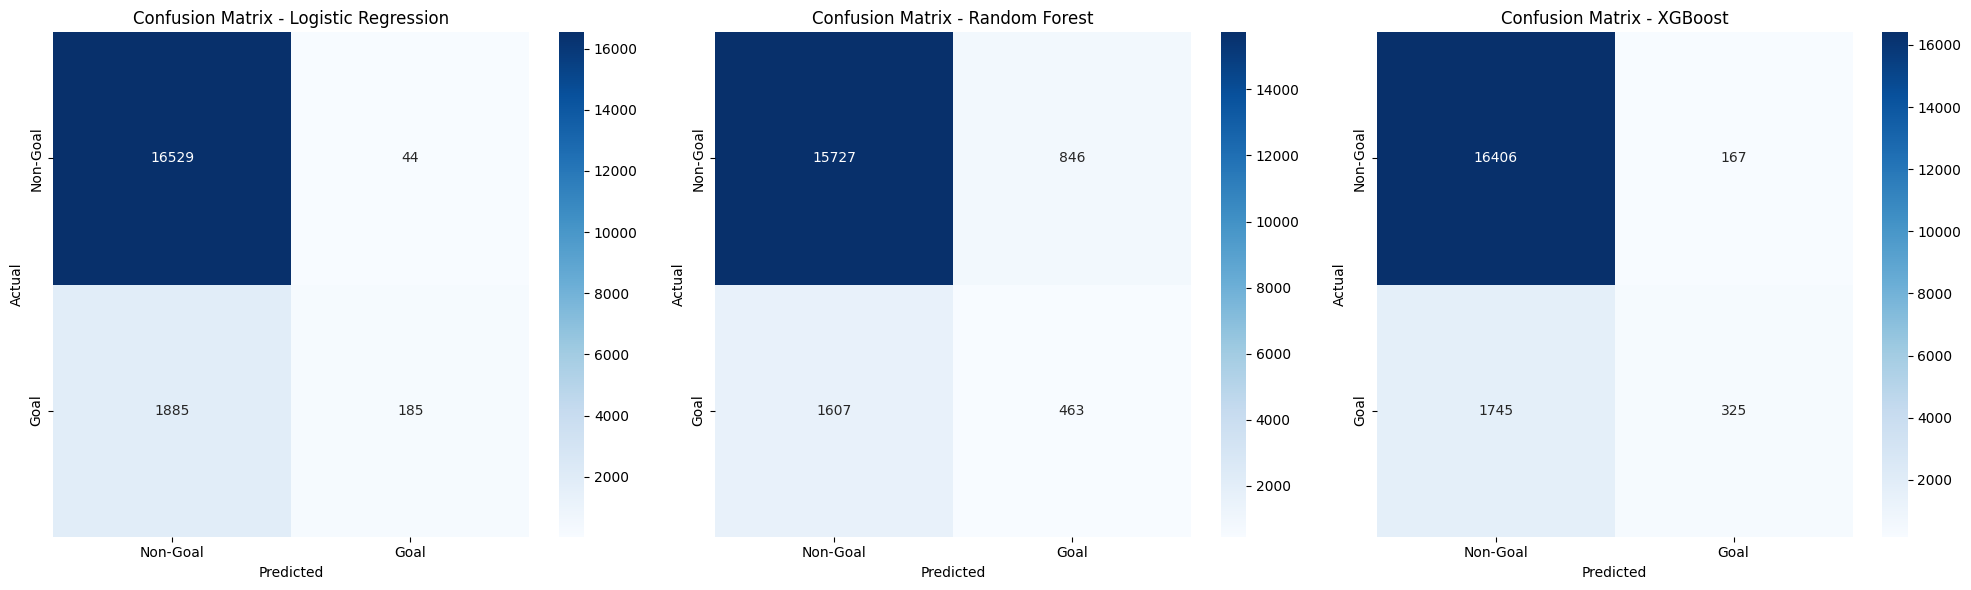

In [100]:
# Confusion Matrices
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

# Plotting confusion matrices in subplots
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Logistic Regression Confusion Matrix
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues', ax=ax[0],
            xticklabels=['Non-Goal', 'Goal'], yticklabels=['Non-Goal', 'Goal'])
ax[0].set_title('Confusion Matrix - Logistic Regression')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

# Random Forest Confusion Matrix
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', ax=ax[1],
            xticklabels=['Non-Goal', 'Goal'], yticklabels=['Non-Goal', 'Goal'])
ax[1].set_title('Confusion Matrix - Random Forest')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')

# XGBoost Confusion Matrix
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', ax=ax[2],
            xticklabels=['Non-Goal', 'Goal'], yticklabels=['Non-Goal', 'Goal'])
ax[2].set_title('Confusion Matrix - XGBoost')
ax[2].set_xlabel('Predicted')
ax[2].set_ylabel('Actual')

plt.tight_layout()
plt.show()

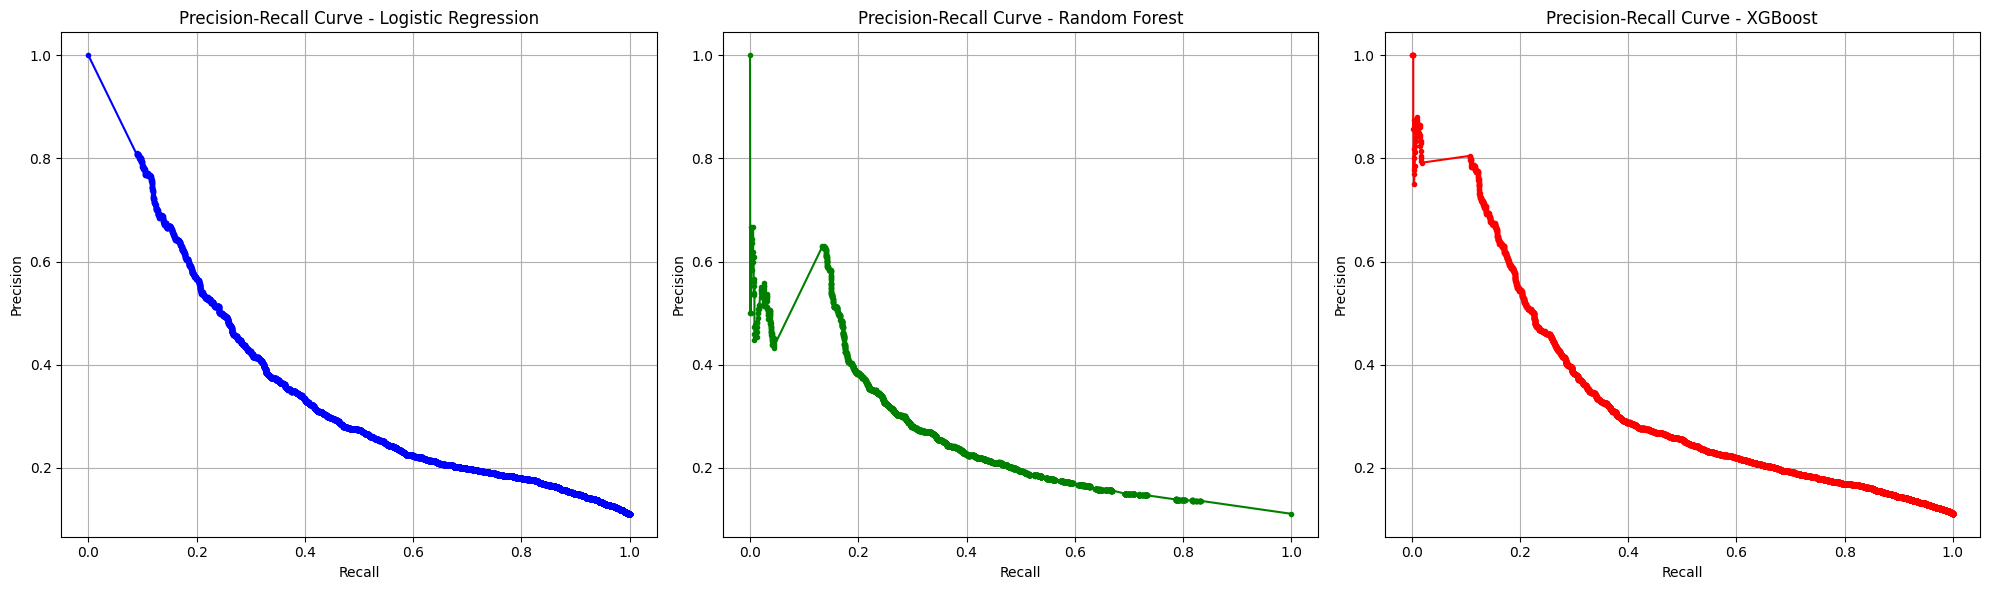

In [101]:
# Compute Precision-Recall curve for each model
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_prob_lr)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_prob_rf)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_prob_xgb)

# Plotting Precision-Recall curves in subplots
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Logistic Regression Precision-Recall Curve
ax[0].plot(recall_lr, precision_lr, marker='.', color='b')
ax[0].set_xlabel('Recall')
ax[0].set_ylabel('Precision')
ax[0].set_title('Precision-Recall Curve - Logistic Regression')
ax[0].grid(True)

# Random Forest Precision-Recall Curve
ax[1].plot(recall_rf, precision_rf, marker='.', color='g')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision-Recall Curve - Random Forest')
ax[1].grid(True)

# XGBoost Precision-Recall Curve
ax[2].plot(recall_xgb, precision_xgb, marker='.', color='r')
ax[2].set_xlabel('Recall')
ax[2].set_ylabel('Precision')
ax[2].set_title('Precision-Recall Curve - XGBoost')
ax[2].grid(True)

plt.tight_layout()
plt.show()

These results (the Confusion Matrix & Precision-Recall Curves) suggests indeed that the XGBoost model is more suitable to our analysis, and actually performs exceptionnaly well in identifying wether a shot is a goal or not. 
### Let us now see which are the features that impacted the most the decision making of our model

# Convert the scaled X_train back to a DataFrame to retain feature names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=features)

# Train XGBoost again using the DataFrame with feature names (if not already done in first part)
xgb_model.fit(X_train_scaled_df, y_train)

# Plot feature importance with correct feature names
plt.figure(figsize=(10, 8))  # Adjust figure size if needed
xgb.plot_importance(xgb_model, importance_type='weight')  # You can also try 'gain' or 'cover' types
plt.title('XGBoost Feature Importance')
plt.ylabel('Features')
plt.show()

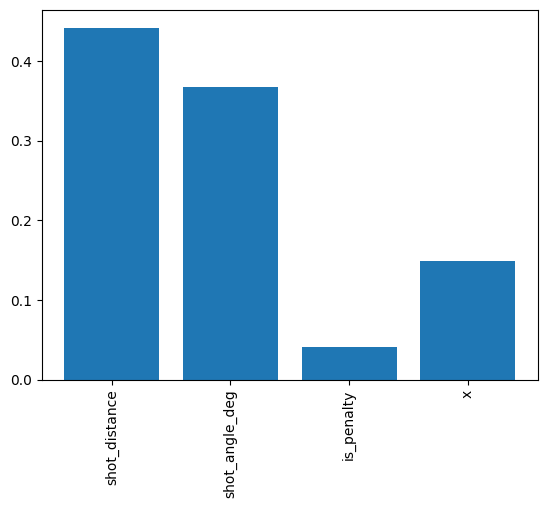

In [103]:
from sklearn.ensemble import RandomForestClassifier
coefficients=rf_model.feature_importances_
coefficients=np.reshape(coefficients,(4,))
plt.bar(features, coefficients)
plt.xticks(rotation=90)
plt.show()

### The XGBoost model’s feature importance analysis provides valuable insights into the factors that most significantly contribute to predicting whether a shot results in a goal. The feature importance is measured by the number of times a feature is used to split the data (F-score). 

Based on the analysis, the most influential features are as follows:

1. Goal Mouth Z (F-score: 801): This feature has the highest importance score, indicating that the vertical position of the shot within the goal is the most significant predictor of scoring probability. Shots aimed higher in the goal are more likely to result in a goal, suggesting that goalkeepers find it harder to save shots targeted at the upper portions of the goal.

2. The minute : This suggests that time plays a crucial role in determining the likelihood of scoring, likely reflecting changes in player fatigue, game dynamics, and tactics as the match progresses. For example, increased risk-taking or pressure in later stages of a match may create better scoring opportunities.


3. Shot Angle (Degrees) : The angle at which a shot is taken also plays a crucial role in determining the likelihood of scoring. Shots from more central angles are favored, implying that a direct approach towards the goal is more advantageous. This feature ranks second in importance, highlighting its relevance in assessing scoring potential.
   
4. Y Position : The horizontal position of the shooter, or ‘Y’ coordinate, affects the probability of scoring. Shots taken from more central positions (closer to the middle of the goal) generally have a higher chance of success. This feature’s importance underscores the advantage of shooting from a central location on the field.
   
5. Shot Distance : Proximity to the goal significantly influences scoring chances. Shots taken from shorter distances have a higher likelihood of resulting in a goal, emphasizing the advantage of being closer to the goal when attempting a shot.
   
6. Was Blocked : The feature indicating whether a shot was blocked contributes less significantly to the model’s predictions. While blocking is a relevant factor, its lower score suggests that it is less influential compared to the positional and distance-related features.
   
7. Is Penalty (F-score: 16): The presence of a penalty kick has the lowest importance score. Despite penalties being high-scoring opportunities, their low importance score in this model may result from their rarity and the model’s reliance on other features like shot position and angle, which provide more detailed context for predicting goals.

In [104]:
X_copy = X.copy()  # Create a copy of the DataFrame
xg_predictions = xgb_model.predict_proba(X_copy)[:, 1]  # Get probability for 'goal' (class 1)

# Add xG values to your test dataset without the warning
X_copy.loc[:, 'xG'] = xg_predictions

In [105]:
X_copy

,shot_distance,shot_angle_deg,is_penalty,x,xG
75,8.082871,71.834043,0,117.48,0.065264
217,22.761125,4.838899,0,97.32,0.055489
296,10.888600,23.834263,0,110.04,0.134681
305,13.346160,19.249526,0,107.40,0.136052
395,20.838157,55.242243,0,108.12,0.018996
...,...,...,...,...,...
3620425,17.855061,27.483542,0,104.16,0.087177
3620465,22.684056,13.252090,0,97.92,0.081549
3620482,16.468005,3.341944,0,103.56,0.069356
3620509,29.998187,33.690068,0,95.04,0.015243


In [106]:
X_copy.sort_values(by='xG',ascending=False,inplace=True)
X_copy

,shot_distance,shot_angle_deg,is_penalty,x,xG
242845,2.183575,8.426969,0,117.84,0.952084
2833853,2.183575,8.426969,0,117.84,0.952084
3352958,1.578354,8.746162,0,118.44,0.952084
1759259,1.578354,8.746162,0,118.44,0.952084
3035897,1.862901,14.931417,0,118.20,0.936260
...,...,...,...,...,...
2820034,35.056640,35.104491,0,91.32,0.000953
10397,20.780029,74.251548,0,114.36,0.000928
1318917,39.312593,15.945396,0,82.20,0.000911
86957,34.927033,34.454451,0,91.20,0.000857


In [107]:
X_copy.corr()

,shot_distance,shot_angle_deg,is_penalty,x,xG
shot_distance,1.000000,-0.165868,-0.075889,-0.945852,-0.571399
shot_angle_deg,-0.165868,1.000000,-0.155967,0.448173,-0.129652
is_penalty,-0.075889,-0.155967,1.000000,0.043470,0.568540
x,-0.945852,0.448173,0.043470,1.000000,0.478387
xG,-0.571399,-0.129652,0.568540,0.478387,1.000000


Text(0.5, 1.0, 'Probability of Scoring Based on shot_angle')

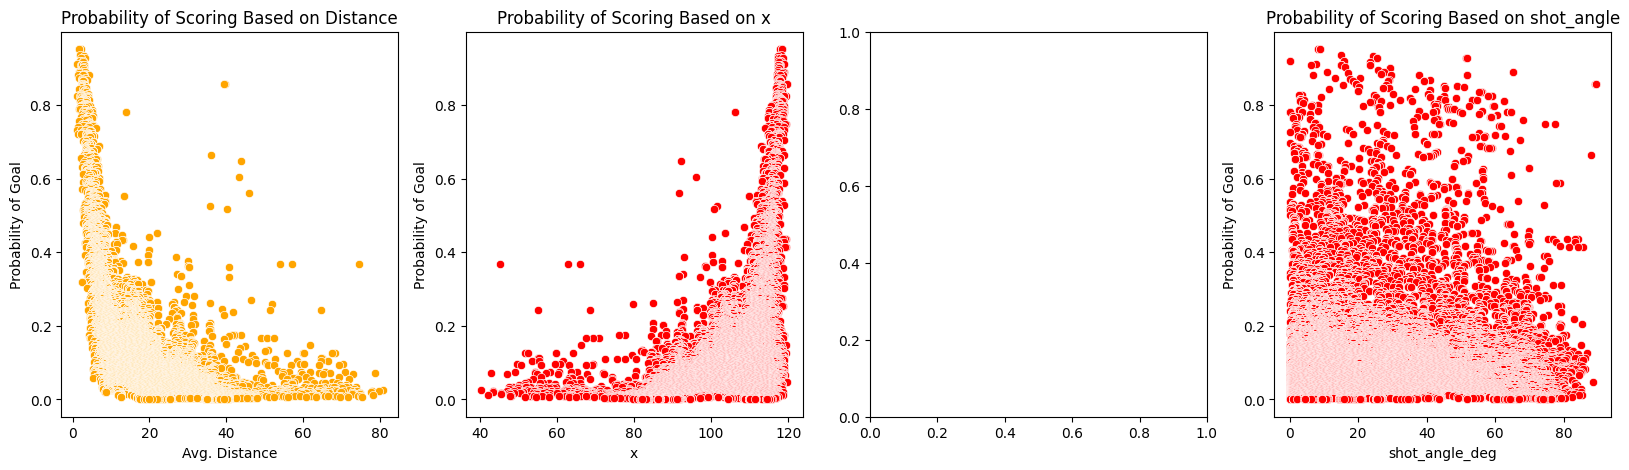

In [109]:
# 1. Probability of Scoring Based on Distance
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

sns.scatterplot(x=X_copy['shot_distance'], y=X_copy['xG'], ax=axes[0], color="orange")
axes[0].set_xlabel("Avg. Distance")
axes[0].set_ylabel("Probability of Goal")
axes[0].set_title("Probability of Scoring Based on Distance")

sns.scatterplot(x=X_copy['x'], y=X_copy['xG'], ax=axes[1], color="red")
axes[1].set_xlabel("x")
axes[1].set_ylabel("Probability of Goal")
axes[1].set_title("Probability of Scoring Based on x")

#sns.scatterplot(x=X_copy['y'], y=X_copy['xG'], ax=axes[2], color="blue")
#axes[2].set_xlabel("y")
#axes[2].set_ylabel("Probability of Goal")
#axes[2].set_title("Probability of Scoring Based on y")

sns.scatterplot(x=X_copy['shot_angle_deg'], y=X_copy['xG'], ax=axes[3], color="red")
axes[3].set_xlabel("shot_angle_deg")
axes[3].set_ylabel("Probability of Goal")
axes[3].set_title("Probability of Scoring Based on shot_angle")

penalty_test = X_copy[X_copy['is_penalty']==1]
penalty_test

AttributeError: 'DataFrame' object has no attribute 'y'

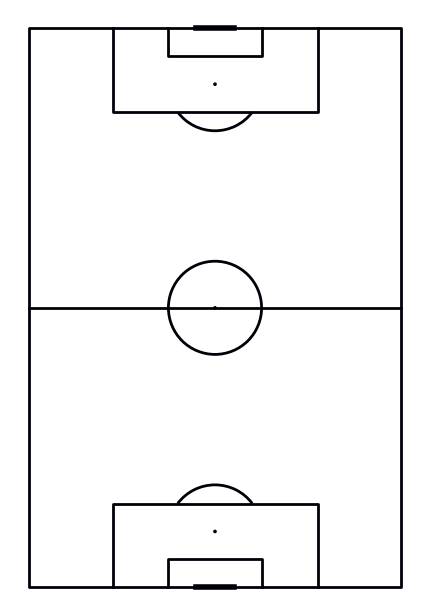

In [110]:
pitch = VerticalPitch(line_color='#000009', line_zorder=2)

fig, ax = pitch.draw(figsize=(4.4, 6.4))

# Scatter plot
scatter = pitch.scatter(X_copy.x, X_copy.y, ax=ax, color='black', s=X_copy.xG*500, edgecolor='white', linewidth=0.6, alpha=0.7)

plt.show()

In [111]:
query = "SELECT * FROM match_events_2023_24"
df_events2 = pd.read_sql(query, engine)

In [112]:
def transform_data(df_events):
    
    # Apply transformations to x and y coordinates (intially 100 x 100)
    for col in ['x', 'end_x','blocked_x']:
        df_events.loc[:, col] *= 1.2
    for col in ['y', 'end_y', 'blocked_y', 'goal_mouth_y']:
        df_events.loc[:, col] = 80 - (df_events[col] * 0.8)    

    df_shots = df_events[(df_events['is_shot']==1) & (df_events['x']>40)]

    df_shots.loc[:, 'is_penalty'] = np.where((df_shots['x'] == 106.2) & (df_shots['y'] == 40), 1, 0)
    
    #columns_to_drop = ['id', 'match_id', 'event_id', 'second','team_id', 'player_id', 
    #                   'qualifiers', 'card_type', 'outcome_type_display_name','is_touch',
    #                  'period_display_name','end_x','end_y']
    #df_shots = df_shots.drop(columns=columns_to_drop)

    # Mapping logic: 1 = on target, 0 = off target
    df_shots['is_on_target'] = df_shots['type_display_name'].map({
        'MissedShots': 0,
        'SavedShot': 1,
        'ShotOnPost': 0,
        'Goal': 1
    })

    df_shots['is_blocked'] = df_shots['blocked_x'].notna().astype(int)
    df_shots['distance_blocker_goal'] = np.sqrt((df_shots['blocked_x'] - 120)**2 + (df_shots['blocked_y'] - 40)**2)
    df_shots['distance_shooter_blocker'] = np.sqrt((df_shots['blocked_x'] - df_shots['x'])**2 + (df_shots['blocked_y'] - df_shots['y'])**2)
    
    columns_to_drop = ['type_display_name','is_shot']
    df_shots = df_shots.drop(columns=columns_to_drop)
    
    # Goal center coordinates
    goal_x = 120
    goal_y = 40
    
    # Calculate shot distance
    df_shots['shot_distance'] = np.sqrt((df_shots['x'] - goal_x)**2 + (df_shots['y'] - goal_y)**2)
    
    # Calculate shot angle in radians
    df_shots['shot_angle'] = np.arctan2(np.abs(df_shots['y'] - goal_y), np.abs(goal_x - df_shots['x']))
    
    # Convert angle to degrees (optional)
    df_shots['shot_angle_deg'] = np.degrees(df_shots['shot_angle'])
    
    df_shots = df_shots.drop(columns=['shot_angle'])

    return df_shots


In [113]:
df_shots2 = transform_data(df_events2)

/var/folders/2v/q5fxrfkj08s4gx6nrq6bhgqc0000gn/T/ipykernel_88858/3328663388.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shots.loc[:, 'is_penalty'] = np.where((df_shots['x'] == 106.2) & (df_shots['y'] == 40), 1, 0)
/var/folders/2v/q5fxrfkj08s4gx6nrq6bhgqc0000gn/T/ipykernel_88858/3328663388.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shots['is_on_target'] = df_shots['type_display_name'].map({
/var/folders/2v/q5fxrfkj08s4gx6nrq6bhgqc0000gn/T/ipykernel_88858/3328663388.py:26: SettingWith

In [114]:
df_shots2

,id,match_id,event_id,minute,second,team_id,player_id,x,y,end_x,...,is_goal,outcome_type_display_name,period_display_name,is_penalty,is_on_target,is_blocked,distance_blocker_goal,distance_shooter_blocker,shot_distance,shot_angle_deg
75,2602367713,1734766,41,4,13.0,60,370000,117.48,47.68,NaN,...,0,Successful,FirstHalf,0,0,0,NaN,NaN,8.082871,71.834043
217,2602380121,1734766,99,12,40.0,60,345908,97.32,41.92,NaN,...,0,Successful,FirstHalf,0,1,1,2.285607,20.475781,22.761125,4.838899
296,2602385821,1734766,151,17,2.0,60,79840,110.04,35.60,NaN,...,0,Successful,FirstHalf,0,0,0,NaN,NaN,10.888600,23.834263
305,2602386809,1734766,158,17,56.0,60,79840,107.40,35.60,NaN,...,0,Successful,FirstHalf,0,0,0,NaN,NaN,13.346160,19.249526
395,2602392055,1734766,253,23,46.0,54,395188,108.12,22.88,NaN,...,0,Successful,FirstHalf,0,0,0,NaN,NaN,20.838157,55.242243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3620425,2691617883,1734856,630,78,29.0,131,395321,104.16,31.76,NaN,...,0,Successful,SecondHalf,0,0,0,NaN,NaN,17.855061,27.483542
3620465,2691619727,1734856,746,81,23.0,839,109807,97.92,45.20,NaN,...,0,Successful,SecondHalf,0,0,0,NaN,NaN,22.684056,13.252090
3620482,2691620905,1734856,758,82,59.0,839,362735,103.56,39.04,NaN,...,0,Successful,SecondHalf,0,1,1,11.302955,5.165578,16.468005,3.341944
3620509,2691621701,1734856,671,84,8.0,131,118479,95.04,56.64,NaN,...,0,Successful,SecondHalf,0,1,1,2.433105,27.629202,29.998187,33.690068


In [115]:
# Step 1: Create a copy of the original DataFrame
df_shots2_copy = df_shots2.copy()

# Step 2: Select the features used for model training (numeric columns)
features = ['shot_distance', 'shot_angle_deg', 'is_penalty', 'x']

# Step 3: Create a subset DataFrame with only the features required for prediction
df_shots2_numeric = df_shots2_copy[features]

# Step 4: Generate xG predictions based on the selected numeric columns
xg_predictions = xgb_model.predict_proba(df_shots2_numeric)[:, 1]  # Get probability for 'goal' (class 1)

# Step 5: Add the xG predictions back to the original DataFrame
df_shots2_copy['xG'] = xg_predictions

# Now, df_shots2_copy contains all columns including non-numeric ones and the xG predictions

In [116]:
df_shots2_copy.head()

,id,match_id,event_id,minute,second,team_id,player_id,x,y,end_x,...,outcome_type_display_name,period_display_name,is_penalty,is_on_target,is_blocked,distance_blocker_goal,distance_shooter_blocker,shot_distance,shot_angle_deg,xG
75,2602367713,1734766,41,4,13.0,60,370000,117.48,47.68,NaN,...,Successful,FirstHalf,0,0,0,NaN,NaN,8.082871,71.834043,0.065264
217,2602380121,1734766,99,12,40.0,60,345908,97.32,41.92,NaN,...,Successful,FirstHalf,0,1,1,2.285607,20.475781,22.761125,4.838899,0.055489
296,2602385821,1734766,151,17,2.0,60,79840,110.04,35.60,NaN,...,Successful,FirstHalf,0,0,0,NaN,NaN,10.888600,23.834263,0.134681
305,2602386809,1734766,158,17,56.0,60,79840,107.40,35.60,NaN,...,Successful,FirstHalf,0,0,0,NaN,NaN,13.346160,19.249526,0.136052
395,2602392055,1734766,253,23,46.0,54,395188,108.12,22.88,NaN,...,Successful,FirstHalf,0,0,0,NaN,NaN,20.838157,55.242243,0.018996


In [117]:
query = "SELECT * FROM players_info_2023_24"
df_players = pd.read_sql(query, engine)

In [118]:
df_players

,player_id,player_name,age,team_id,team_name,main_position,second_position,third_position
0,2987,Pepe Reina,41,839,Villarreal,GK,None,None
1,4511,James Milner,38,211,Brighton,MID,LB,RB
2,6227,Dani Rodríguez,35,51,Mallorca,LW,MID,None
3,6683,Dante,40,613,Nice,CB,None,None
4,8105,Andy Lonergan,40,31,Everton,None,None,None
...,...,...,...,...,...,...,...,...
4495,527638,Matteo Palma,16,86,Udinese,None,None,None
4496,527644,Lander Emery,21,24,Aston-Villa,None,None,None
4497,527670,Tidiane Diallo,17,148,Strasbourg,None,None,None
4498,527718,Junior Ajayi,19,76,Verona,None,None,None


In [119]:
xg_team = df_shots2_copy.groupby('team_id')[['xG','is_goal']].sum().reset_index()

In [120]:
xg_team.sort_values(by='xG',ascending=False,inplace=True)
xg_team

,team_id,xG,is_goal
51,129,93.528046,108
4,26,87.355873,80
77,256,83.503433,90
11,37,80.879578,93
0,13,80.442558,86
...,...,...,...
113,1147,34.098881,28
43,108,32.966534,35
130,9509,31.519747,37
55,143,31.289310,32


In [121]:
df_teams = df_players[['team_id', 'team_name']].drop_duplicates()

In [122]:
xg_team = pd.merge(xg_team, df_teams,on='team_id')

In [123]:
xg_team.head()

,team_id,xG,is_goal,team_name
0,129,93.528046,108,PSV-Eindhoven
1,26,87.355873,80,Liverpool
2,256,83.503433,90,Feyenoord
3,37,80.879578,93,Bayern-Munich
4,13,80.442558,86,Arsenal


In [124]:
xg_player = df_shots2_copy.groupby('player_id')[['xG','is_goal']].sum().reset_index()
xg_player = pd.merge(xg_player,df_players[['player_id','player_name','team_name']],on='player_id')

In [125]:
xg_player.sort_values(by='xG',ascending=False,inplace=True)
xg_player.head()

,player_id,xG,is_goal,player_name,team_name
110,68585,27.853266,29,Luuk de Jong,PSV-Eindhoven
199,83532,25.961655,36,Harry Kane,Bayern-Munich
1063,315227,24.399530,27,Erling Haaland,Manchester-City
944,296975,20.007750,24,Artem Dovbyk,Girona
1577,362815,19.564529,29,Viktor Gyökeres,Sporting-CP


In [126]:
xg_team['xG-G'] = xg_team['xG']-xg_team['is_goal']
xg_player['xG-G'] = xg_player['xG']-xg_player['is_goal']

xg_team.sort_values(by='xG-G',ascending=True,inplace=True)
xg_player.sort_values(by='xG-G',ascending=True,inplace=True)

In [127]:
xg_team

,team_id,xG,is_goal,team_name,xG-G
8,296,69.446159,93,Sporting-CP,-23.553841
20,52,62.183605,85,Real-Madrid,-22.816395
36,304,55.652596,78,Paris-Saint-Germain,-22.347404
13,36,65.774399,87,Bayer-Leverkusen,-21.225601
69,116,47.317493,67,NEC-Nijmegen,-19.682507
...,...,...,...,...,...
108,1354,40.166367,25,Cadiz,15.166367
41,219,53.588150,38,Mainz-05,15.588150
75,79,46.486237,30,Lecce,16.486237
72,282,46.910290,28,FC-Koln,18.910290


<Axes: xlabel='xG-G'>

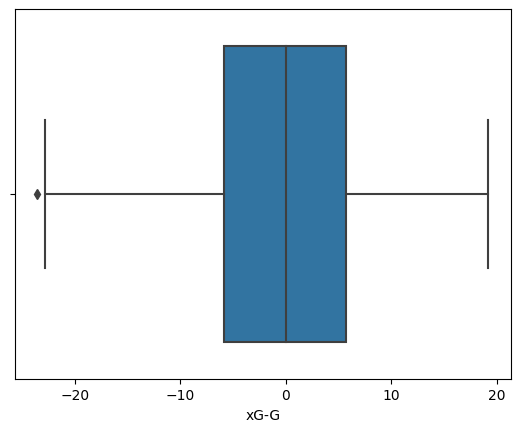

In [128]:
sns.boxplot(x=xg_team["xG-G"])

In [129]:
xg_player = xg_player[xg_player['xG']>5]

<Axes: xlabel='xG-G'>

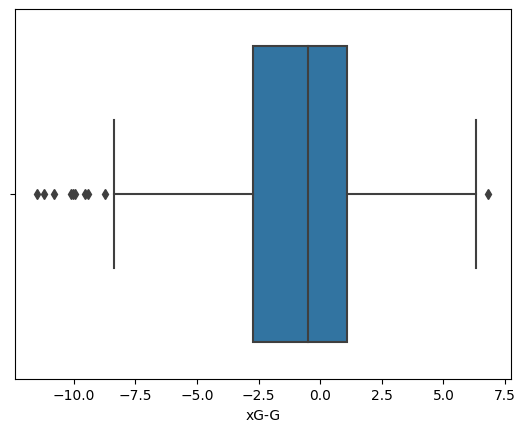

In [130]:
sns.boxplot(x=xg_player["xG-G"])

In [131]:
query = "SELECT * FROM match_events_2024_25"
df_events3 = pd.read_sql(query, engine)

In [133]:
def transform_data(df_events):
    
    # Apply transformations to x and y coordinates (intially 100 x 100)
    for col in ['x', 'end_x','blocked_x']:
        df_events.loc[:, col] *= 1.2
    for col in ['y', 'end_y', 'blocked_y', 'goal_mouth_y']:
        df_events.loc[:, col] = 80 - (df_events[col] * 0.8)    

    df_shots = df_events[(df_events['is_shot']==1) & (df_events['x']>40)]

    df_shots.loc[:, 'is_penalty'] = np.where((df_shots['x'] == 106.2) & (df_shots['y'] == 40), 1, 0)
    
    #columns_to_drop = ['id', 'match_id', 'event_id', 'second','team_id', 'player_id', 
    #                   'qualifiers', 'card_type', 'outcome_type_display_name','is_touch',
    #                  'period_display_name','end_x','end_y']
    #df_shots = df_shots.drop(columns=columns_to_drop)

    # Mapping logic: 1 = on target, 0 = off target
    df_shots['is_on_target'] = df_shots['type_display_name'].map({
        'MissedShots': 0,
        'SavedShot': 1,
        'ShotOnPost': 0,
        'Goal': 1
    })

    df_shots['is_blocked'] = df_shots['blocked_x'].notna().astype(int)
    df_shots['distance_blocker_goal'] = np.sqrt((df_shots['blocked_x'] - 120)**2 + (df_shots['blocked_y'] - 40)**2)
    df_shots['distance_shooter_blocker'] = np.sqrt((df_shots['blocked_x'] - df_shots['x'])**2 + (df_shots['blocked_y'] - df_shots['y'])**2)
    
    columns_to_drop = ['type_display_name','is_shot']
    df_shots = df_shots.drop(columns=columns_to_drop)
    
    # Goal center coordinates
    goal_x = 120
    goal_y = 40
    
    # Calculate shot distance
    df_shots['shot_distance'] = np.sqrt((df_shots['x'] - goal_x)**2 + (df_shots['y'] - goal_y)**2)
    
    # Calculate shot angle in radians
    df_shots['shot_angle'] = np.arctan2(np.abs(df_shots['y'] - goal_y), np.abs(goal_x - df_shots['x']))
    
    # Convert angle to degrees (optional)
    df_shots['shot_angle_deg'] = np.degrees(df_shots['shot_angle'])
    
    df_shots = df_shots.drop(columns=['shot_angle'])

    return df_shots

In [134]:
df_shots3 = transform_data(df_events3)

/var/folders/2v/q5fxrfkj08s4gx6nrq6bhgqc0000gn/T/ipykernel_88858/970341968.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shots.loc[:, 'is_penalty'] = np.where((df_shots['x'] == 106.2) & (df_shots['y'] == 40), 1, 0)
/var/folders/2v/q5fxrfkj08s4gx6nrq6bhgqc0000gn/T/ipykernel_88858/970341968.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shots['is_on_target'] = df_shots['type_display_name'].map({
/var/folders/2v/q5fxrfkj08s4gx6nrq6bhgqc0000gn/T/ipykernel_88858/970341968.py:26: SettingWithCop

In [135]:
# Step 1: Create a copy of the original DataFrame
df_shots3_copy = df_shots3.copy()

# Step 2: Select the features used for model training (numeric columns)
features = ['shot_distance', 'shot_angle_deg', 'is_penalty', 'x']

# Step 3: Create a subset DataFrame with only the features required for prediction
df_shots3_numeric = df_shots3_copy[features]

# Step 4: Generate xG predictions based on the selected numeric columns
xg_predictions = xgb_model.predict_proba(df_shots3_numeric)[:, 1]  # Get probability for 'goal' (class 1)

# Step 5: Add the xG predictions back to the original DataFrame
df_shots3_copy['xG'] = xg_predictions

# Now, df_shots2_copy contains all columns including non-numeric ones and the xG predictions

In [136]:
df_shots3_copy

,id,match_id,event_id,minute,second,team_id,player_id,x,y,end_x,...,outcome_type_display_name,period_display_name,is_penalty,is_on_target,is_blocked,distance_blocker_goal,distance_shooter_blocker,shot_distance,shot_angle_deg,xG
24,2706934411,1822174,19,2,13.0,758,79967,93.84,50.72,NaN,...,Successful,FirstHalf,0,1,1,18.851843,9.422696,28.271257,22.283128,0.010618
30,2706934731,1822174,24,2,35.0,758,321106,97.56,53.28,NaN,...,Successful,FirstHalf,0,1,1,23.011232,3.073760,26.075122,30.617062,0.054903
69,2706936555,1822174,35,4,45.0,783,484534,89.16,23.84,NaN,...,Successful,FirstHalf,0,0,0,NaN,NaN,34.817398,27.654305,0.006901
85,2706938913,1822174,63,7,40.0,758,79967,106.20,40.00,NaN,...,Successful,FirstHalf,1,1,0,NaN,NaN,13.800000,0.000000,0.781855
93,2706939645,1822174,50,8,43.0,783,423275,100.92,24.80,NaN,...,Successful,FirstHalf,0,1,1,2.786252,21.608332,24.394393,38.542429,0.022997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312658,2716750397,1836649,716,90,21.0,107,422205,104.76,42.88,NaN,...,Successful,SecondHalf,0,1,0,NaN,NaN,15.509739,10.701351,0.083921
312782,2716751857,1836645,894,96,3.0,290,464528,108.12,56.40,NaN,...,Successful,SecondHalf,0,1,1,14.986767,5.264219,20.250788,54.080795,0.031722
312814,2716752153,1836645,898,96,44.0,290,442247,114.60,41.52,NaN,...,Successful,SecondHalf,0,1,1,4.115337,1.494523,5.609848,15.720928,0.201392
312823,2716752197,1821462,1014,95,57.0,52,445649,91.44,59.20,NaN,...,Successful,SecondHalf,0,1,1,32.096679,2.327230,34.413858,33.911714,0.002461


In [ ]:
query = "SELECT * FROM players_info_2024_25"
df_players3 = pd.read_sql(query, engine)